In [1]:
import time
from IPython.display import display

import pandas as pd

from crawler import *
from bandits import *
from arms import *

# WikiBandits

## Goal

We want to create a testground for different Contextual Multi-Armed Bandit (CMAB) ssetups to explore wikipedia around a certain subject. Bandwith and storage is limited and thus a decision to download must ideally be made before teh actual content is known, based on the limited context provided by previos downloads, the url considered, meta-information in the header like the size,... the latter being the major source of regret.

We want to attain a state of our algoritm where it makes an acceptable selection before most of our bandwith has been used, and thus returns an acceptable selection from that moment on.

## Crawler - Bandits - Arms

### Crawler

A number of tools are set up in [crawler.py](crawler.py), most notably the _Crawler_ class looking like this:

In [2]:
class Crawler:
    '''
    Tool to iterate pages for a given subject using a specified bandit-evaluator
    '''
    def __init__(self, url0, subject,log,bandit):
        self.current_url = url0
        self.subject = subject
        self.log = log.add_url(url0,True)
        self.bandit = bandit
    def pop(self):
        '''Pops next candidate from front of the queue'''
        self.current_url = self.bandit.pop(self.log)
        return self
    def process(self):
        ''' Perform bandit action and rewarding'''
        self.bandit.action(self.current_url,self.subject,self.log)

        key = urlkey(self.current_url)
        if (path := self.log.nodes.at[key,'path']) and pd.notna(path):
            with open(path,'r',encoding="utf8") as file:
                content = file.readlines()
            size = self.log.nodes.at[key,'size']
            res = self.bandit.reward(self.current_url,self.subject,content,size = size)
            self.log.nodes.at[key,'reward'] = res
        return self
    def done(self,max_pages,max_size):
        '''Signal ending criterium'''
        # progress = round(20 * self.log.size() / max_size)
        # print(''.join(['0']*progress + ['.']*(20-progress)))
        return self.log.length() >= max_pages or self.log.size() >= max_size


It starts from a number of context variables: a _subject_, a _url_ and a _log_ (that starts out empty of course) and a **Bandit** that statistically determines the course of action in each successive step.

### Bandit

The **Bandit** contains a number of **Arms** en makes a well considered choice at every turn, depending on the context and each past successes. All example-Bandits have 2 arms, but this is not a constraint.

One **Bandit** looks like this:

In [3]:
class Lefty(Bandit):
    '''
    Bandit with only one relevant arm, scoring positive or negative,
    pitched against the nothing option.
    Exploring the right arm is in fact useless here.
    '''
    def __init__(self,**kwargs):
        super().__init__(arms.Classifier(**kwargs),arms.LameArm())
        self.epsilon = kwargs.get('epsilon',0.1)
        self.current_arm = None
    def reward(self,url,subject,content,**metric):
        return self.arms[self.current_arm].reward(url,subject,content,**metric)
    def pick_arm(self,url,subject):
        '''epsilon-greedy approach'''
        if np.random.rand() > self.epsilon:
            return 0 if self.arms[0].estimate(url,subject) > 0 else 1
        return np.random.randint(0,2)
    def action(self,url,subject,log):
        '''classifies the context-representation according the Evaluators current state'''
        self.current_arm = self.pick_arm(url,subject)
        arm = self.arms[self.current_arm]
        return arm.action(url,subject,log)

It typically can do 3 things: 
- pick an arm from the context, which is sometimes called the _policy_. 
- run the selected arm's action, which for us is mostly a download and an update of the log
- calculate the reward after the action is performed.

The latter action in the code depends on the content, which is only provided by the action. It will also always modify the arm's state to account for its (lack of) success.

One of our more advanced Bandits can additionally steer the course of the _Crawler_, we'll come back to that.

### Arm

The last main ingredient of our workflow are the **Arms**. An example is provided below:

In [4]:
class Classifier(Arm):
    '''
    Class to evaluate relevance of a <url,subject,size> context using logistic regression
    from a pretrained word2vec model.
    '''
    def __init__(self,**parameters):
        '''
        @param max_size: size in bytes
        @param lr: learning rate fro SGD
        '''
        super().__init__(**parameters)
        self.classifier = Sequential(Linear(2,2),Softmax(dim=-1))
        self.loss = CrossEntropyLoss()
        self.mean = 0
        self.var = 0
        self.runs = 0
    def _evaluate(self,url,subject):
        '''
        Helper function to create an intermediate representation
        for both the context and its estimated effect
        '''
        context_representation = torch.Tensor([ wiki_relevance(url,subject),
                                    wiki_size(url,self._parameters.get('max_size',MAX_SIZE))])
        return self.classifier(context_representation)
    def estimate(self,url,subject,new_case = True):
        '''estimate of the reward based on the internal state'''
        res = self._evaluate(url,subject)
        est = (res[1] - res[0]).item()
        if new_case:
            self.runs +=1
            self.var += ((est - self.mean) ** 2 - self.var)/self.runs
            self.mean += (est - self.mean) / self.runs 
        return est
    def action(self,url,subject,log):
        estimate =  self.estimate(url,subject)
        log.add_url(url,True,estimate = estimate,arm = self.name)
        return estimate
    def _response(self,subject,content,size):
        '''
        Custom translation of the resulting content to a reward.
        '''
        return response(subject,content,size/ self._parameters.get('max_size',MAX_SIZE))
    def reward(self,url,subject,content,**metric):
        # get the response and adjest the learning rate accordingly,
        # this way the binary classifier takes the size into account
        response = self._response(subject,content,metric.get('size',0))
        lr = self._parameters.get('lr',0.1) * abs(response)

        # train logistic regressor as usual
        self.classifier.train()
        prediction = self._evaluate(url,subject)
        optimizer = torch.optim.SGD(self.classifier.parameters(), lr=lr)
        loss = self.loss(prediction[None],torch.LongTensor([1 if  response > 0 else 0]))
        self.classifier.zero_grad()
        loss.backward()
        optimizer.step()
        self.classifier.eval()

        return response

We always need it to be able to do 3 things:
- Estimate the reward from the _a priori_ context: the subject, url, history-log
- perform an action: a download revealing the content
- calculate the reward and update the estimator accordingly

This is realized above with a logistic regressor separating positive and negative rewards and a _true_ reward that is for now defined as "occurences of the subject per 1% of the available capacity". This is entirely arbitrary except that it has a positive correlation to a content-match and negative one on size. (_I've chosen to take this reward in [$-1,1$] because the 0-treshhold for downloading seemed clearer, but in hindsight that was not a great choice._)

With these ingredients we can test some scenarios.

## Discover content

We combine the previously defined elements in an iterator, **discover**, that prods the **Crawler**, which provides context to the **Bandit**, which in turn puts on of its **Arms** to work. In this first approach, the _Crawler_ will just go trough every new link it found, successively.

Disregarding the exception-handling the script below is in fact fairly straightforward. Ideally the client code would never **raise**, but some problematic cases remain for now. In particular, many links do not respond well to the wikipedia2vec function used to evaluate the url, and these are now simply skipped.

In [5]:
MAX_TIME = 120

def discover(subject,url0,bandit,log = None):
    if log is None:
        log = SubjectLog(subject)
    queue = Crawler(url0,subject,log,bandit)
    t0 = time.time()
    try:
        while not queue.done(MAX_PAGES,MAX_SIZE) and time.time() < (t0 + MAX_TIME):
            attempt = 0
            while (attempt := attempt + 1) <= 20:
                try: queue.pop().process()
                except PropsFetchError: 
                    log.nodes.append(pd.Series(name=urlkey(queue.current_url),dtype=object))
                    #print('props error ',queue.current_url)
                    continue
                break
            time.sleep(0.1) # don't want to freak out wikipedia
    except EmptyQueue:
        print('Exhausted links')
    log.plot(MAX_SIZE)
    display(log.nodes.head())
    return log.nodes

Now we are ready to do some exploring. We need a topic and a good start url, for example:

In [6]:
subject = 'entropy'
url = 'https://en.wikipedia.org/wiki/Thermodynamics'

and a **Bandit** to do the discovering for us:

In [7]:
bandit = Lefty(max_size = MAX_SIZE)

This particular bandit has in fact only one working (left) arm, which is the _Classifier_ defined before. It uses logistic regression with cross entropy loss to find a good estimater. The working arm will always download the page and consider it a mistake if the response function was negative (more bytes than subject-occurences). 

This way it should learn when a positive outcome is to be expected, based on the provided context, which is the file size we get from the url-header, but also a pretrained word2vec overlap between subject and link.

The good arm is pitched against a non-downloading neutral arm. While this way we get all the exploratory needs of a true bandit-problem, it deviates in the sense that the reward of the _Lame Arm_ is always known, also if the good one is chosen.

Let's see how it performs:

,url,size,linkage,estimate,reward,arm,path
Thermodynamics,https://en.wikipedia.org/wiki/Thermodynamics,56053,940,NaN,NaN,NaN,repos/entropy/Thermodynamics.html
Carnot heat engine,https://en.wikipedia.org/wiki/Carnot_heat_engine,NaN,NaN,0,0,Arm1,NaN
Carnot cycle,https://en.wikipedia.org/wiki/Carnot_cycle,NaN,NaN,0,0,Arm1,NaN
Statistical mechanics,https://en.wikipedia.org/wiki/Statistical_mech...,NaN,NaN,0,0,Arm1,NaN
Chemical thermodynamics,https://en.wikipedia.org/wiki/Chemical_thermod...,NaN,NaN,0,0,Arm1,NaN


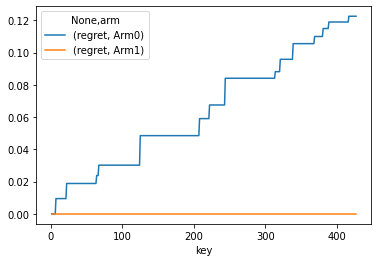

In [8]:
res = discover(subject,url,bandit)

The plot shows the cumulative regret, defined here as the fraction of our capacity used if the response was negative, but 0 otherwise.

Near the end the regret of the first arm should start to flatten, preferring the other arm when it would grow too much. The greedy approach however ensures that it will sporadically keep making regrettable choices. It seems here that downloading is never preferred, both the short learning time or the very negatively weighted rewards might be the cause.

## Alternative Bandits

Having defined the _Crawler_ to accept a generic type of _Bandit_, which in turn accepts a generic type of _Arms_, we can play around with other scenarios.

### Cramped Arm

First question that pops up could be whether the binarry classifier used before could perform better worse than a straight up linear regressor. We could simply pitch the against each other in a bandit problem, as a proof of concept. Of course this is an academic setting: both would perform the same action, take the same reward and even have the size-cntext-parameter in common, we are merely testing which can map the word2vec-url-representation best to a subject count here. A Bandit for this is already defined in _bandits.py_, let's see what it does:

,url,size,linkage,estimate,reward,arm,path
Thermodynamics,https://en.wikipedia.org/wiki/Thermodynamics,56053,940,NaN,NaN,NaN,repos/entropy/Thermodynamics.html
Carnot heat engine,https://en.wikipedia.org/wiki/Carnot_heat_engine,22701,132,-0.530285,-0.004540,Arm3,repos/entropy/Carnot_heat_engine.html
Carnot cycle,https://en.wikipedia.org/wiki/Carnot_cycle,33596,350,-0.387356,-0.006719,Arm3,repos/entropy/Carnot_cycle.html
Statistical mechanics,https://en.wikipedia.org/wiki/Statistical_mech...,38218,470,-0.306216,-0.007644,Arm3,repos/entropy/Statistical_mechanics.html
Chemical thermodynamics,https://en.wikipedia.org/wiki/Chemical_thermod...,29465,392,-0.183723,-0.005893,Arm3,repos/entropy/Chemical_thermodynamics.html


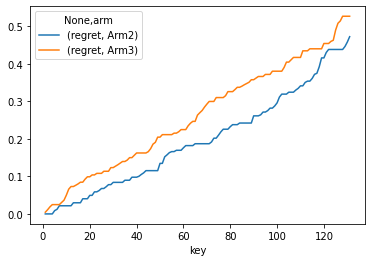

In [9]:
cramped_bandit = Crampy(max_size = MAX_SIZE)
res = discover(subject,url,cramped_bandit)

The second arm uses the new linear regressor. The bandit uses a different exploration method, switching arms until the difference is sufficient clear of the Hoeffding bound. Not unexpectedly, both perform similarly and the bond is not yet reached. As indicated, this was more a conceptual test case.

### True Bandit

All problems above consider context about the same page for each arm, gaining the same insight after the act. While this allows to use Bandit-techniques, it is not a bandit problem in essence. This requires that the different action gain different insights unatainable by the other, and thus different rewards.

One deviation of our current approach that touches that is creating a bandit that picks between url's to download.

We now pick next url's [fifo](https://en.wikipedia.org/wiki/FIFO_(computing_and_electronics))-wise, but we could imagine our discoveratory path more like a random walk in the already built-up network of hyperlinks from downloaded pages. Many choices could be relevant, depending on the context, but imagine we have a dual option: pick the most connected link of either the current pages siblings (sharing parents) or children (linked by current). 

One could imagine the latter being more efficient in among less relevant pages, because it moves out of the current bubble, and the former to do the converse. While this could be an over-simplification, it would be a nice exercise to put this to the test. 

The **SubjectLog** class was designed for this, it contains all information about downloaded pages, including their connectedness as a graph and metrics to make the plots. From this we can easily extract alternative url's in a graph visiting fashion.

A family structure learning bandit is defined in _bandits.py_ and perform exactly the above, using an $\epsilon$-greedy method and evaluating both link-options with the classifier we already had.

,url,size,linkage,estimate,reward,arm,path
Thermodynamics,https://en.wikipedia.org/wiki/Thermodynamics,56053,940,NaN,NaN,NaN,repos/entropy/Thermodynamics.html
ISBN (identifier),https://en.wikipedia.org/wiki/ISBN_(identifier),60399,902,NaN,-0.01208,Arm5,repos/entropy/ISBN_(identifier).html
OCLC (identifier),https://en.wikipedia.org/wiki/OCLC_(identifier),40516,298,0.350672,-0.008103,Arm5,repos/entropy/OCLC_(identifier).html
Doi (identifier),https://en.wikipedia.org/wiki/Doi_(identifier),43178,695,0.346929,-0.008636,Arm5,repos/entropy/Doi_(identifier).html
Wikipedia:Contact us,NaN,NaN,NaN,NaN,NaN,NaN,NaN


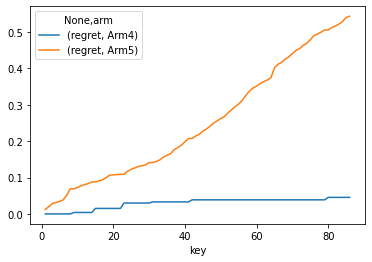

In [10]:
log = SubjectLog(subject)
genealogist = Genealogist(log,max_size = MAX_SIZE)
res = discover(subject,url,genealogist,log)

The above used a greedy method, occasionaly invoking the lesser arm. It is however unclear form this _how much_ better the other one is performing.

## Conclusion

* We've looked at a few ways extract an _a priori_ metric from url-subject combinations, using a word2vec approach and the yet recorded connectedness to other pages. 
* Next we've added different evaluation methods called **Arms** to translate this metric to a cost function. Logistic and linear regression were used, as well as teh accumulated $erf()$ function from linkage. 
* Finally we've used two exploratory methods to pitch **Arms** against each other in **Bandits** that download pages based on the resulting best fit.

The code seems to be working as expected returning a subset of pages based on the **Bandits** decisions and its **Arms** are updating. This should allow a successful, self-learning, storage-aware downloader.

However, for now the quantitative results are quite disappointing. Certainly the _ad-hoc_ reward function is lacking, so there's no real example to learn from, and training samples were kept very limited. As such, it is hard to evaluate the success of either methods.